In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from scipy import signal

from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis import detect_peaks
from kid_readout.analysis.resonator import find_resonators, lmfit_resonator

In [2]:
plot_directory = '/home/flanigan/temp/'

In [3]:
npd = npy.NumpyDirectory('/data/readout/2017-11-25_152629_scans.npd/')

In [4]:
print(npd.metadata.script_code)

"""
Scan a large frequency range at a given frequency resolution. At each LO frequency, scan most of the positive baseband
frequencies and save one SweepArray.
"""
from __future__ import division
import time

import numpy as np

from kid_readout.roach import analog, hardware_tools, tools
from kid_readout.measurement import acquire, basic, core
from kid_readout.equipment import hardware, starcryo_temps

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)


# Parameters
suffix = 'scans'
attenuations = [0]
df_baseband_target = 25e3
f_start = 3100e6
f_stop = 4000e6
overlap_fraction = 0.5
f_baseband_minimum = 10e6  # Keep the tones above the LO by at least this frequency
f_baseband_maximum = 180e6  # Keep the tones below this frequency
length_seconds = 0.01
filterbank_bin_separation = 4  # The minimum number of PFB bins that separate tones
f_lo_resolution = 2.5e3  # The minimum
num_tones_maximum = 128  # Imposed by the data streaming rate

# Hardwa

In [5]:
npd.node_names()

['Scan0',
 'ADCSnap1',
 'ADCSnap2',
 'ADCSnap3',
 'ADCSnap4',
 'ADCSnap5',
 'ADCSnap6',
 'ADCSnap7',
 'ADCSnap8',
 'ADCSnap9',
 'ADCSnap10',
 'ADCSnap11',
 'ADCSnap12',
 'ADCSnap13',
 'ADCSnap14',
 'ADCSnap15',
 'ADCSnap16',
 'ADCSnap17',
 'ADCSnap18',
 'ADCSnap19',
 'ADCSnap20',
 'ADCSnap21',
 'ADCSnap22',
 'ADCSnap23',
 'ADCSnap24',
 'ADCSnap25',
 'ADCSnap26',
 'ADCSnap27',
 'ADCSnap28',
 'ADCSnap29',
 'ADCSnap30',
 'ADCSnap31',
 'ADCSnap32',
 'ADCSnap33',
 'ADCSnap34',
 'ADCSnap35',
 'ADCSnap36',
 'ADCSnap37',
 'ADCSnap38',
 'ADCSnap39',
 'ADCSnap40',
 'ADCSnap41',
 'ADCSnap42',
 'ADCSnap43',
 'ADCSnap44',
 'ADCSnap45',
 'ADCSnap46',
 'ADCSnap47',
 'ADCSnap48',
 'ADCSnap49',
 'ADCSnap50',
 'ADCSnap51',
 'ADCSnap52',
 'ADCSnap53',
 'ADCSnap54',
 'ADCSnap55',
 'ADCSnap56',
 'ADCSnap57',
 'ADCSnap58',
 'ADCSnap59',
 'ADCSnap60',
 'ADCSnap61',
 'ADCSnap62',
 'ADCSnap63',
 'ADCSnap64',
 'ADCSnap65',
 'ADCSnap66',
 'ADCSnap67',
 'ADCSnap68',
 'ADCSnap69',
 'ADCSnap70',
 'ADCSnap71',
 'ADC

In [6]:
scans = [npd.read(name) for name in npd.node_names() if name.startswith('Scan')]

In [7]:
snaps = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

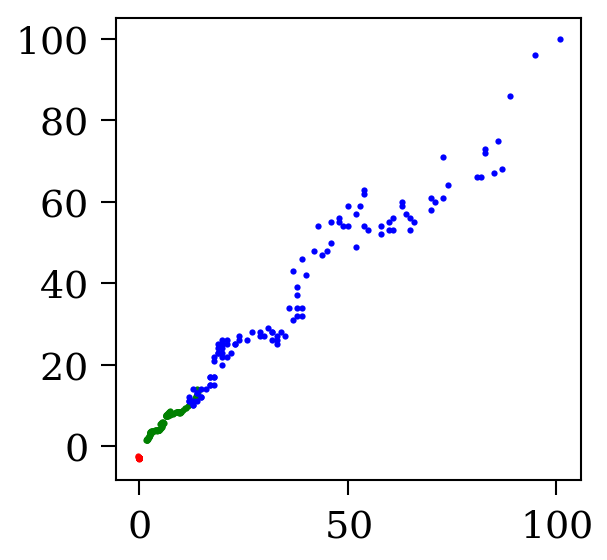

In [8]:
fig, ax = plt.subplots(figsize=(2, 2))
for snap in snaps:
    ax.plot(snap.x.mean(), snap.y.mean(), '.r')    
    ax.plot(snap.x.std(), snap.y.std(), '.g')
    ax.plot(snap.x.ptp(), snap.y.ptp(), '.b')

# Functions

In [9]:
def remove_background(f, s21, amp_degree=3, phi_degree=3, weights=None):
    if weights is None:
        weights = np.abs(s21)**2
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return s21 / (np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f)))

# Raw data

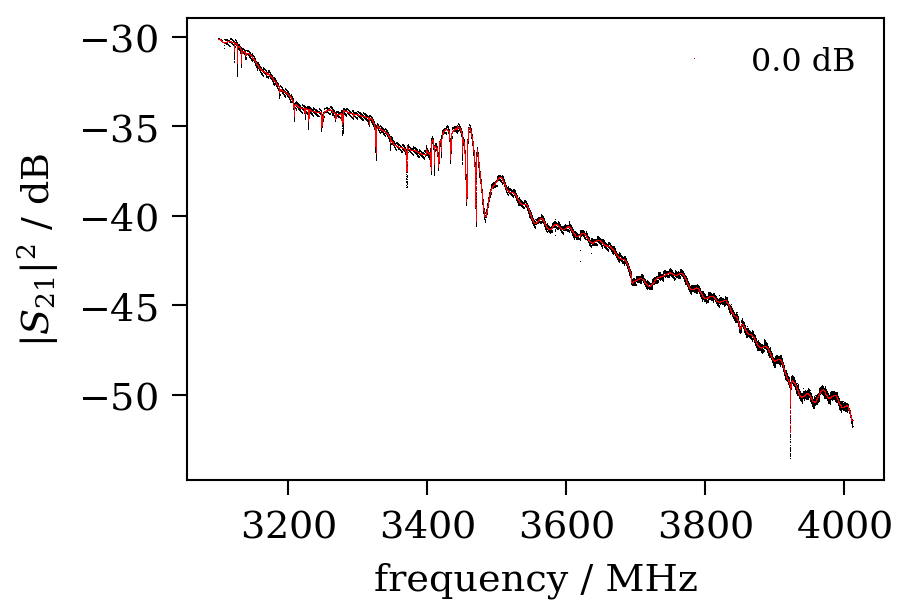

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz', rotation='horizontal')
ax.set_ylabel('$|S_{21}|^2$ / dB', rotation='vertical')
ax.set_yscale('linear')
ax.set_yscale('linear')
for scan in scans:
    for sa in scan.sweep_arrays:
        ax.plot(sa.frequency_MHz, 20 * np.log10(np.abs(sa.s21_point)), ',k')
    frequency, amplitude, smoothed = scan.stitch()
    ax.plot(1e-6 * frequency, 20 * np.log10(smoothed), ',r',
            label='{:.1f} dB'.format(scan.sweep_arrays[0].stream_arrays[0].roach_state.dac_attenuation))
ax.legend(fontsize='x-small');

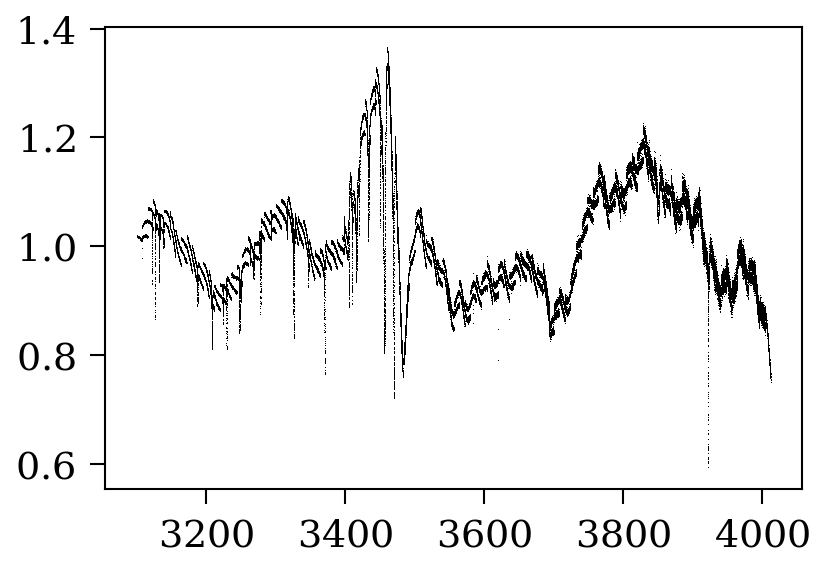

In [11]:
f_full = np.concatenate([sa.frequency_MHz for sa in scans[0].sweep_arrays])
s21_full = np.concatenate([sa.s21_point for sa in scans[0].sweep_arrays])
full_poly = np.polyfit(f_full, np.abs(s21_full), deg=4)
fig, ax = plt.subplots()
ax.plot(f_full, np.abs(s21_full) / np.polyval(full_poly, f_full), ',k')

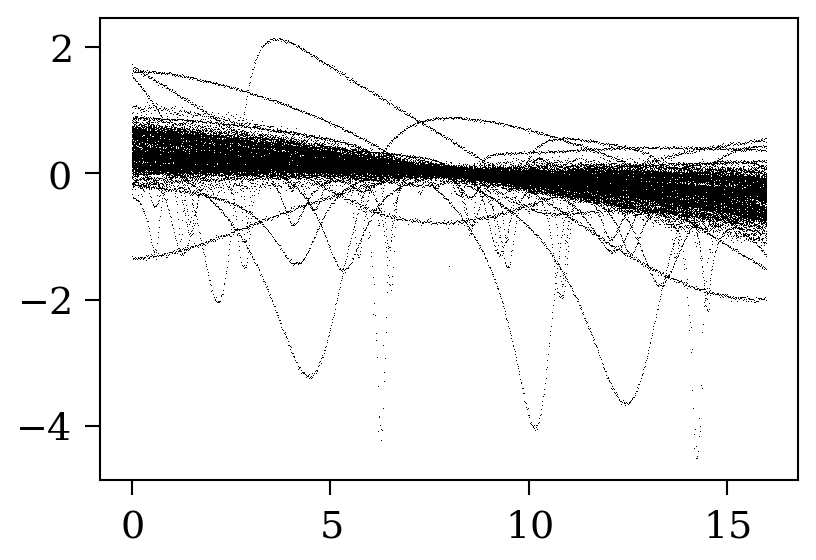

In [12]:
fig, ax = plt.subplots()
for sa in scans[0].sweep_arrays:
    ax.plot(sa.frequency_MHz - sa.frequency_MHz.min(),
            20 * np.log10(np.abs(sa.s21_point) / np.median(np.abs(sa.s21_point))),
            ',k')